In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

blackhatcoder21_multilingual_meme_datasets_path = kagglehub.dataset_download('blackhatcoder21/multilingual-meme-datasets')

print('Data source import complete.')


Using device: cuda
Found 25716 images in directory
Successfully mapped 25432 out of 25432 unique names
Train set: 17920, Validation set: 3840, Test set: 3840
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] Train Loss: 0.7746 Train Acc: 0.6607 Valid Loss: 0.6320 Valid Acc: 0.6786
Saved model with validation loss: 75.8376
Epoch [2/10] Train Loss: 0.5830 Train Acc: 0.6841 Valid Loss: 0.5834 Valid Acc: 0.6797
Saved model with validation loss: 70.0058
Epoch [3/10] Train Loss: 0.5645 Train Acc: 0.6892 Valid Loss: 0.5672 Valid Acc: 0.6826
Saved model with validation loss: 68.0609
Epoch [4/10] Train Loss: 0.5550 Train Acc: 0.6968 Valid Loss: 0.5491 Valid Acc: 0.7021
Saved model with validation loss: 65.8908
Epoch [5/10] Train Loss: 0.5524 Train Acc: 0.6953 Valid Loss: 0.5742 Valid Acc: 0.6945
Epoch [6/10] Train Loss: 0.5464 Train Acc: 0.6991 Valid Loss: 0.5443 Valid Acc: 0.6893
Saved model with validation loss: 65.3219
Epoch [7/10] Train Loss: 0.5406 Train Acc: 0.7010 Valid Loss: 0.5437 Valid Acc: 0.6969
Saved model with validation loss: 65.2406
Epoch [8/10] Train Loss: 0.5403 Train Acc: 0.7073 Valid Loss: 0.5303 Valid Acc: 0.6958
Saved model with validation loss: 63.6350
Epoch [9/1

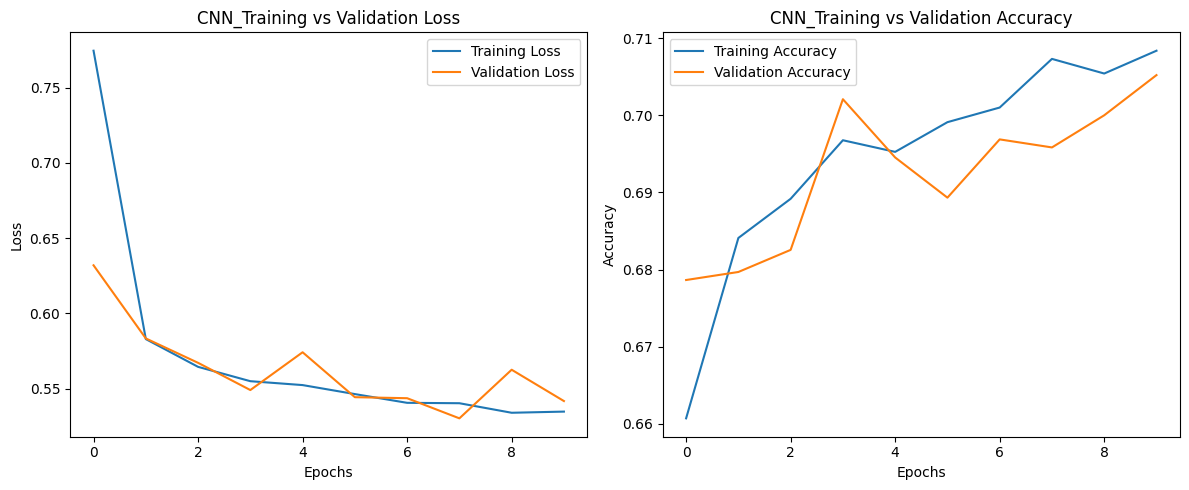


Evaluating model on test set...


/tmp/ipykernel_31/1780980464.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))
/usr/local/lib/python3.11/dist-pac

Test Accuracy: 0.7031

Confusion Matrix:
[[ 233  999]
 [ 141 2467]]

Classification Report:
              precision    recall  f1-score   support

 Non-Harmful       0.62      0.19      0.29      1232
     Harmful       0.71      0.95      0.81      2608

    accuracy                           0.70      3840
   macro avg       0.67      0.57      0.55      3840
weighted avg       0.68      0.70      0.64      3840



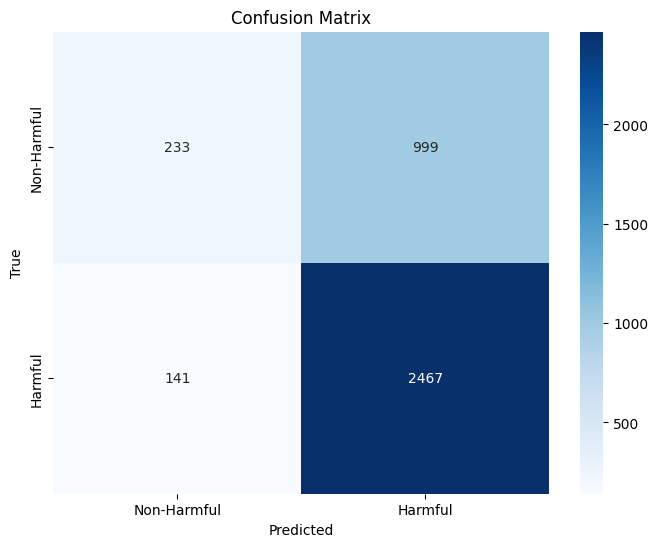

CNN model training and evaluation complete!


In [ ]:
# ----------------------------------------------
# Imports
# ----------------------------------------------
import os
import re
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# from transformers import BertTokenizer, BertModel


# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----------------------------------------------
# Create Image Mapping
# ----------------------------------------------
def create_image_mapping(dataframe, image_directory):
    image_files = glob.glob(os.path.join(image_directory, '*'))
    image_mapping = {}

    available_images = {os.path.basename(f) for f in image_files}
    print(f"Found {len(available_images)} images in directory")

    for name in dataframe['name'].unique():
        if name in available_images:
            image_mapping[name] = name

    unmapped_names = set(dataframe['name']) - set(image_mapping.keys())
    for name in unmapped_names:
        id_match = re.search(r'\d+', name)
        if id_match:
            id_value = id_match.group()
            matching_files = [f for f in available_images if id_value in f]
            if matching_files:
                image_mapping[name] = matching_files[0]

    # Method 3: Try matching using 'ids' or 'id' column if available
    if 'ids' in dataframe.columns or 'id' in dataframe.columns:
        id_col = 'ids' if 'ids' in dataframe.columns else 'id'
        id_to_name = dict(zip(dataframe[id_col], dataframe['name']))

        for id_value, name in id_to_name.items():
            if name not in image_mapping:
                # Look for files containing this ID
                matching_files = [f for f in available_images if str(id_value) in f]
                if matching_files:
                    image_mapping[name] = matching_files[0]


    print(f"Successfully mapped {len(image_mapping)} out of {len(dataframe['name'].unique())} unique names")
    return image_mapping

# ----------------------------------------------
# Dataset Class
# ----------------------------------------------
class HarmfulContentDataset(Dataset):
    def __init__(self, dataframe, image_dir, image_mapping=None, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.image_mapping = image_mapping

        self.blank_image = Image.new('RGB', (224, 224), color='white')

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        try:
            image_filename = self.image_mapping.get(row['name'], row['name'])
            image_path = os.path.join(self.image_dir, image_filename)

            if os.path.exists(image_path):
                image = Image.open(image_path).convert('RGB')
            else:
                base_name = os.path.splitext(image_path)[0]
                for ext in ['.jpg', '.jpeg', '.png', '.gif']:
                    alt_path = base_name + ext
                    if os.path.exists(alt_path):
                        image = Image.open(alt_path).convert('RGB')
                        break
                else:
                    image = self.blank_image
                    if idx % 100 == 0:
                        print(f"Image not found for {row['name']}, using blank image")

            image_tensor = self.transform(image)

        except Exception as e:
            if idx % 100 == 0:
                print(f"Error processing image for {row['name']}: {e}")
            image_tensor = torch.zeros((3, 224, 224))

        return {
            'image': image_tensor,
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

# ----------------------------------------------
# Model
# ----------------------------------------------
class SimpleCNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNNClassifier, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 256),  # if input was 224x224
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.classifier(x)
        return x

# ----------------------------------------------
# Training
# ----------------------------------------------
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch in valid_loader:
                images = batch['image'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_losses[-1]:.4f} Train Acc: {train_accuracies[-1]:.4f} "
              f"Valid Loss: {valid_losses[-1]:.4f} Valid Acc: {valid_accuracies[-1]:.4f}")


        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step(valid_loss)

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'Saved model with validation loss: {valid_loss:.4f}')


    return train_losses, valid_losses, train_accuracies, valid_accuracies

# ----------------------------------------------
# Evaluation
# ----------------------------------------------
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())




    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=['Non-Harmful', 'Harmful'])

    print(f'Test Accuracy: {accuracy:.4f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Harmful', 'Harmful'],
                yticklabels=['Non-Harmful', 'Harmful'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('CNN_confusion_matrix.png')
    plt.show()

    return accuracy, conf_matrix, class_report

# Function to plot training curves
def plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN_Training vs Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN_Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('CNN_training_curves.png')
    plt.show()



# ----------------------------------------------
# Driver Code
# ----------------------------------------------

# Load your dataset
df = pd.read_csv('/kaggle/input/multilingual-meme-datasets/final_datasets.csv')
image_dir = '/kaggle/input/multilingual-meme-datasets/datasets/datasets'

# Create image mapping
image_mapping = create_image_mapping(df, image_dir)

# Split into train and valid
from sklearn.model_selection import train_test_split



train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set: {len(train_df)}, Validation set: {len(valid_df)}, Test set: {len(test_df)}")

# Create datasets and dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HarmfulContentDataset(train_df, image_dir, image_mapping, transform)
valid_dataset = HarmfulContentDataset(valid_df, image_dir, image_mapping, transform)
test_dataset = HarmfulContentDataset(test_df, image_dir, image_mapping, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model, Loss, Optimizer
model = SimpleCNNClassifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train model
print("Starting training...")
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=10
)

# Plot training curves
plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Load best model for evaluation
model.load_state_dict(torch.load('best_cnn_model.pth'))

# Evaluate model
print("\nEvaluating model on test set...")
accuracy, conf_matrix, class_report = evaluate_model(model, test_loader)

# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'accuracy': accuracy,
    'conf_matrix': conf_matrix,
    'class_report': class_report,
}, 'CNN_harmful_content_classifier.pth')

print("CNN model training and evaluation complete!")

# Helper function to inspect dataset
def inspect_dataset(df, image_dir):
    """
    Inspects the dataset and the image directory to understand the structure.
    """
    print("\n=== Dataset Inspection ===")
    print(f"Dataset columns: {df.columns.tolist()}")
    print(f"Number of rows: {len(df)}")
    print(f"Label distribution: {df['label'].value_counts().to_dict()}")

    # Check if image directory exists
    if not os.path.exists(image_dir):
        print(f"WARNING: Image directory does not exist: {image_dir}")
        return

    # Count image files
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and
                   f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    print(f"Number of image files in directory: {len(image_files)}")
    if len(image_files) > 0:
        print(f"Sample image filenames: {image_files[:5]}")

    # Check name column format
    print("\nSample names from dataset:")
    print(df['name'].head(5).tolist())

    # Check if any dataset names exactly match image filenames
    matching_names = [name for name in df['name'].unique() if name in image_files]
    print(f"Number of exact matches between 'name' column and image filenames: {len(matching_names)}")

    # Check if IDs are in the name column
    if 'id' in df.columns or 'ids' in df.columns:
        id_col = 'ids' if 'ids' in df.columns else 'id'
        print(f"\nSample values from '{id_col}' column:")
        print(df[id_col].head(5).tolist())

        # Check if IDs are in image filenames
        sample_ids = df[id_col].astype(str).head(5).tolist()
        for id_val in sample_ids:
            matches = [f for f in image_files if id_val in f]
            if matches:
                print(f"Found matches for ID {id_val}: {matches[:2]}")

    return image_files

